<a href="https://colab.research.google.com/github/yeabsiramoges/AIRMAEnergyForcasting/blob/main/EnergyTimeSeriesForcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pytorch-forecasting

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

<ipython-input-2-dd43299892a5>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


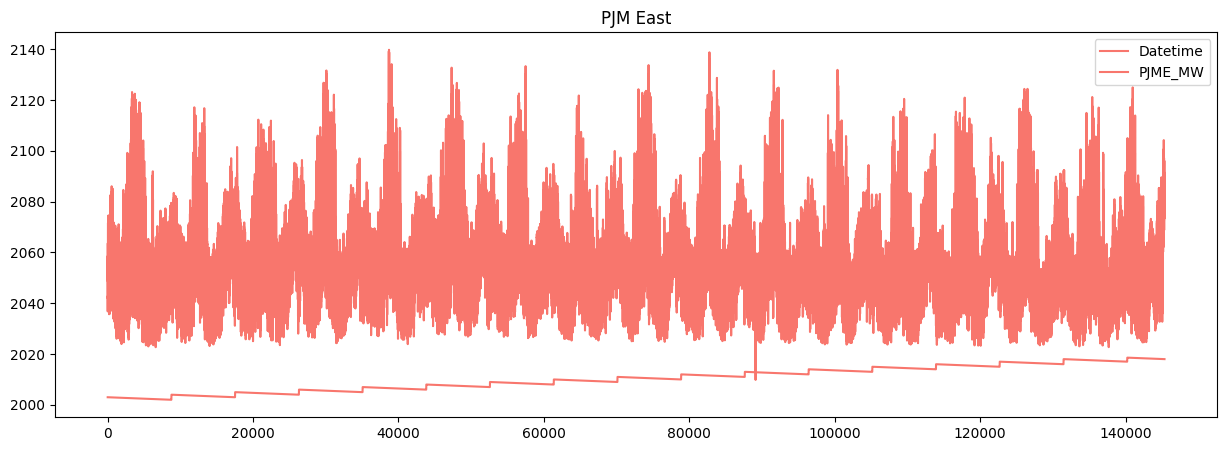

In [3]:
dataset = read_csv('/PJME_hourly.csv', index_col=False, parse_dates=[0])
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
dataset.plot(style='-', figsize=(15,5), color=color_pal[0], title='PJM East')
dataset

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

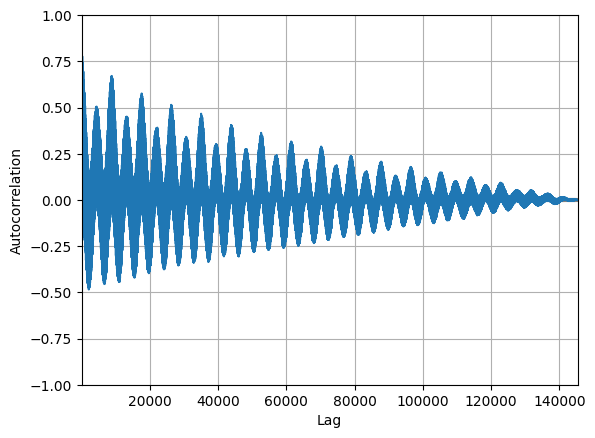

In [4]:
corr_dataset = read_csv('/PJME_hourly.csv', index_col=[0], parse_dates=[0])
autocorrelation_plot(corr_dataset)

In [5]:
# Base imports
import os
import pickle
import warnings
from typing import Dict
# Analysis imports
import numpy as np
import pandas as pd
# Torch imports
import torch
from torch import nn
from pytorch_forecasting import Baseline
from pytorch_forecasting.models import BaseModel
from pytorch_forecasting.metrics import MAE
from pytorch_forecasting.data.timeseries import TimeSeriesDataSet
from torch.nn.utils import rnn
from pytorch_forecasting.models.base_model import AutoRegressiveBaseModel
from pytorch_forecasting.models.nn import LSTM
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.utilities.model_summary import ModelSummary
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

warnings.filterwarnings('ignore')

In [6]:
class FCModule(nn.Module):
  '''
  Fully connected neural network module.
  '''
  def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, activation: str):
    super().__init__()
    net = []

    activation_fn = None

    match activation:
      case 'ReLu':
        activation_fn = nn.ReLU()
      case 'TanH':
        activation_fn = nn.Tanh()

    # input layer
    net.extend([
        nn.Linear(input_size, hidden_size),
        activation_fn
    ])

    # hidden layers
    for _ in range(n_hidden_layers):
      net.extend([
          nn.Linear(hidden_size, hidden_size),
          activation_fn
      ])

    # output layer
    net.extend([
        nn.Linear(hidden_size, output_size)
    ])
    self.sequential = nn.Sequential(*net)

  def forward(self, data: torch.Tensor) -> torch.Tensor:
    '''
    Performs forward step of module.
    Args:
      data: batch_size x n_timesteps_in shape tensor
    Return:
      Tensor module compuation output
    '''
    return self.sequential(data)

In [7]:
# Module Parameters
input_size = 5
output_size = 2
hidden_size = 10
n_hidden_layers = 2
activation = 'ReLu'

# FCM Init Test
module = FCModule(
    input_size,
    output_size,
    hidden_size,
    n_hidden_layers,
    activation
)

# Sample Data and Modeling
data = torch.rand(20, 5)
module(data).shape


torch.Size([20, 2])

In [8]:
class FCModel(BaseModel):
  '''
  Fully connected model implimented using FCModule.
  '''
  def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, activation: str, **kwargs):
    '''
    Initialize fully connected model with all arguments.
    '''
    # Save args to .hparams attrib.
    self.save_hyperparameters()
    super().__init__(**kwargs)
    self.model = FCModule(
        input_size=self.hparams.input_size,
        output_size=self.hparams.input_size,
        hidden_size=self.hparams.input_size,
        n_hidden_layers=self.hparams.input_size,
        activation=self.hparams.activation
    )

  def forward(self, data: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    # Data in the form of TimeSeriesDataset
    input_data = data['encoder_count'].squeeze(-1)
    prediction = self.model(input_data)

    # Scale predictions into target space
    predictions = self.transform_output(
        prediction,
        target_scale=data['target_scale']
    )

    # Conver to named tuple and mode data
    return self.to_network_output(prediction)

In [9]:
from pytorch_forecasting.metrics.point import F
class LSTMModel(AutoRegressiveBaseModel):
  def __init__(
      self,
      target: str,
      target_lags: Dict[str, Dict[str, int]],
      n_layers: int,
      hidden_size: int,
      dropout: float = 0.1,
      **kwargs,
  ):
    self.save_hyperparameters()
    super().__init__(**kwargs)

    self.lstm = LSTM(
        hidden_size=self.hparams.hidden_size,
        input_size=2,
        num_layers=self.hparams.n_layers,
        dropout=self.hparams.dropout,
        batch_first=True
    )
    self.output_layer = nn.Linear(
        self.hparams.hidden_size,
        1
    )
  def encode(self, data: Dict[str, torch.Tensor]):
    # lag encoding by one timestep to begin
    assert data['encoder_lengths'].min() >= 1

    # input vector and lagging all inputs by one
    input_vector = data['encoder_cont'].clone()
    input_vector[..., self.target_positions] = torch.roll(
        input_vector[..., self.target_positions],
        shifts=1,
        dims=1
    )
    # exclude lagged first timestep
    input_vector = input_vector[:, 1:]

    # finding optimal encoder length and run network
    optimal_lengths = data['encoder_lengths'] - 1
    _, hidden_state = self.lstm(
        input_vector,
        lengths=optimal_lengths,
        enforce_sorted=False
    )

    return hidden_state

  def decode(self, data: Dict[str, torch.Tensor], hidden_state):
    # lag target by one
    input_vector = data['decoder_cont'].clone()
    input_vector[..., self.target_positions] = torch.roll(
        input_vector[..., self.target_positions],
        shifts=1,
        dims=1
    )
    # fill in missing target
    last_encoder_target = data['encoder_cont'][
        torch.arange(
            data['encoder_cont'].size(0),
            device=data['encoder_cont'].device
        ),
        data['encoder_lengths'] - 1,
        self.target_positions.unsqueeze(-1)
    ].T
    input_vector[:, 0, self.target_positions] = last_encoder_target

    # training computation
    if self.training:
      # compute output
      lstm_output, _ = self.lstm(
          input_vector,
          hidden_state,
          lengths=data['decoder_lengths'],
          enforce_sorted=False
      )
      # transform shape
      prediction = self.output_layer(lstm_output)
      return self.transform_output(
          prediction,
          target_scale=data['target_scale']
      )
    # prediction computation
    else:
      target_position = self.target_positions

      def decode_one(idx, lagged_targets, hidden_state):
        data = input_vector[:, [idx]]

        # overwrite at target position to update prediction
        data[:, 0, target_position] = lagged_targets[-1]
        lstm_output, hidden_state = self.lstm(data, hidden_state)

        # transform shape
        prediction = self.output_layer(lstm_output)[:, 0]
        return prediction, hidden_state

      return self.decode_autoregressive(
          decode_one,
          first_target=input_vector[:, 0, target_position],
          first_hidden_state=hidden_state,
          target_scale=data['target_scale'],
          n_decoder_steps=input_vector.size(1)
      )
  def forward(self, data: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    hidden_state = self.encode(data)
    output = self.decode(data, hidden_state)

    return self.to_network_output(prediction=output)

In [10]:
# Edit data with new columns
dataset['group'] = np.repeat(np.arange(13), 11182)
dataset[['Date', 'Time']] = dataset['Datetime'].astype(str).str.split(' ', expand=True)
dataset['Date'] = pd.to_datetime(dataset['Date'], errors='coerce')
dataset['time_idx'] = dataset['Date'].dt.year * 12 + dataset['Date'].dt.month
dataset["time_idx"] -= dataset["time_idx"].min()
dataset.describe()

,PJME_MW,group,time_idx
count,145366.000000,145366.00000,145366.000000
mean,32080.222831,6.00000,99.048264
std,6464.012166,3.74167,57.455550
min,14544.000000,0.00000,0.000000
25%,27573.000000,3.00000,49.000000
50%,31421.000000,6.00000,99.000000
75%,35650.000000,9.00000,149.000000
max,62009.000000,12.00000,199.000000


In [11]:
dataset

,Datetime,PJME_MW,group,Date,Time,time_idx
0,2002-12-31 01:00:00,26498.0,0,2002-12-31,01:00:00,11
1,2002-12-31 02:00:00,25147.0,0,2002-12-31,02:00:00,11
2,2002-12-31 03:00:00,24574.0,0,2002-12-31,03:00:00,11
3,2002-12-31 04:00:00,24393.0,0,2002-12-31,04:00:00,11
4,2002-12-31 05:00:00,24860.0,0,2002-12-31,05:00:00,11
...,...,...,...,...,...,...
145361,2018-01-01 20:00:00,44284.0,12,2018-01-01,20:00:00,192
145362,2018-01-01 21:00:00,43751.0,12,2018-01-01,21:00:00,192
145363,2018-01-01 22:00:00,42402.0,12,2018-01-01,22:00:00,192
145364,2018-01-01 23:00:00,40164.0,12,2018-01-01,23:00:00,192


In [12]:
# Timeseries inputs
max_encoder_length = 24
max_prediction_length = 6
training_cutoff = dataset["time_idx"].max() - max_prediction_length

# Create training ime series dataset from data
training = TimeSeriesDataSet(
    dataset[lambda x: x.time_idx <= training_cutoff],
    group_ids=["group"],
    target='PJME_MW',
    time_idx='time_idx',
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['PJME_MW'],
    allow_missing_timesteps=True,
)

# Validation set
validation = TimeSeriesDataSet.from_dataset(
    training,
    dataset,
    predict=True,
    stop_randomization=True
)

In [13]:
training.get_parameters()

{'time_idx': 'time_idx',
 'target': 'PJME_MW',
 'group_ids': ['group'],
 'weight': None,
 'max_encoder_length': 24,
 'min_encoder_length': 12,
 'min_prediction_idx': 0,
 'min_prediction_length': 1,
 'max_prediction_length': 6,
 'static_categoricals': [],
 'static_reals': ['encoder_length'],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': [],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['PJME_MW'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': True,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': True,
 'target_normalizer': EncoderNormalizer(
 	method='standard',
 	center=True,
 	max_length=None,
 	transformation='relu',
 	method_kwargs={}
 ),
 'categorical_encoders': {'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True)},
 'scalers': {'encoder_length': StandardScaler()},
 'randomize_length': None,
 'predict_mode': False}

In [14]:
validation.get_parameters()

{'time_idx': 'time_idx',
 'target': 'PJME_MW',
 'group_ids': ['group'],
 'weight': None,
 'max_encoder_length': 24,
 'min_encoder_length': 12,
 'min_prediction_idx': 0,
 'min_prediction_length': 6,
 'max_prediction_length': 6,
 'static_categoricals': [],
 'static_reals': ['encoder_length'],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': [],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['PJME_MW'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': True,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': True,
 'target_normalizer': EncoderNormalizer(
 	method='standard',
 	center=True,
 	max_length=None,
 	transformation='relu',
 	method_kwargs={}
 ),
 'categorical_encoders': {'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True)},
 'scalers': {'encoder_length': StandardScaler()},
 'randomize_length': None,
 'predict_mode': True}

In [15]:
batch_size = 128
num_workers = 0

train_dataloader = training.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)
validation_dataloader = validation.to_dataloader(
    train=False,
    batch_size=batch_size * 10,
    num_workers=num_workers
)

In [16]:
baseline_predictions = Baseline().predict(
    validation_dataloader,
    return_y=True
)
MAE()(baseline_predictions.output, baseline_predictions.y)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


tensor(5179.0259)

In [17]:
# confuguring model and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator='cpu',
    gradient_clip_val=0.1
)

model = LSTMModel.from_dataset(
    training,
    learning_rate=0.03,
    dropout=0.1,
    n_layers=4,
    hidden_size=8,
    optimizer='Adam'
)
print(
    ModelSummary(
        model,
        max_depth=-1
    )
)
model.hparams

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | lstm            | LSTM       | 2.1 K 
3 | output_layer    | Linear     | 9     
-----------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)


"dropout":                     0.1
"hidden_size":                 8
"learning_rate":               0.03
"log_gradient_flow":           False
"log_interval":                -1
"log_val_interval":            -1
"logging_metrics":             ModuleList()
"loss":                        SMAPE()
"monotone_constaints":         {}
"n_layers":                    4
"optimizer":                   Adam
"optimizer_params":            None
"output_transformer":          EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
)
"reduce_on_plateau_min_lr":    1e-05
"reduce_on_plateau_patience":  1000
"reduce_on_plateau_reduction": 2.0
"target":                      PJME_MW
"target_lags":                 {}
"weight_decay":                0.0

In [ ]:
result = Tuner(trainer).lr_find(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=validation_dataloader,
    max_lr=1.0,
    min_lr=1e-6
)

print(f"suggested learning rate: {result.suggestion()}")
figure = result.plot(
    show=True,
    suggest=True
)
figure.show()

In [18]:
train_x, train_y = next(iter(train_dataloader))

print(
    'prediction shape in training: ', model(train_x)['prediction'].size()
)
model.eval()
print(
    'prediction shape in interface: ', model(train_x)['prediction'].size()
)

prediction shape in training:  torch.Size([128, 6, 1])
prediction shape in interface:  torch.Size([128, 6, 1])


In [19]:
# params
min_delta = 1e-4
patience = 10
epochs = 50
train_batches = 50

# configuring net and trainer
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=min_delta,
    patience=patience,
    verbose=False,
    mode='min'
)
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger('lighting_logs')
trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator='cpu',
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=train_batches,
#   fast_dev_run=True,
    callbacks=[lr_logger, early_stop],
    logger=logger
)

model = LSTMModel.from_dataset(
    training,
    learning_rate=0.03,
    dropout=0.1,
    n_layers=4,
    hidden_size=10,
    optimizer='Adam',
    reduce_on_plateau_patience=4,
    log_interval=10,
)
print(
    ModelSummary(
        model,
        max_depth=-1
    )
)
model.hparams

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | lstm            | LSTM       | 3.2 K 
3 | output_layer    | Linear     | 11    
-----------------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


"dropout":                     0.1
"hidden_size":                 10
"learning_rate":               0.03
"log_gradient_flow":           False
"log_interval":                10
"log_val_interval":            10
"logging_metrics":             ModuleList()
"loss":                        SMAPE()
"monotone_constaints":         {}
"n_layers":                    4
"optimizer":                   Adam
"optimizer_params":            None
"output_transformer":          EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
)
"reduce_on_plateau_min_lr":    1e-05
"reduce_on_plateau_patience":  4
"reduce_on_plateau_reduction": 2.0
"target":                      PJME_MW
"target_lags":                 {}
"weight_decay":                0.0

In [ ]:
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=validation_dataloader
)

INFO: 
  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | lstm            | LSTM       | 3.2 K 
3 | output_layer    | Linear     | 11    
-----------------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | lstm            | LSTM       | 3.2 K 
3 | output_layer    | Linear     | 11    
-----------------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
pred = model.predict(
    validation_dataloader,
    mode='raw',
    return_x=True
)

for index in range(5):
  model.plot_prediction(
      pred.x,
      pred.output,
      idx=index,
      add_loss_to_title=True
  )